MAE: 11279660.88377193
RMSE: 14708343.72192253
R²: 0.6284581784406412


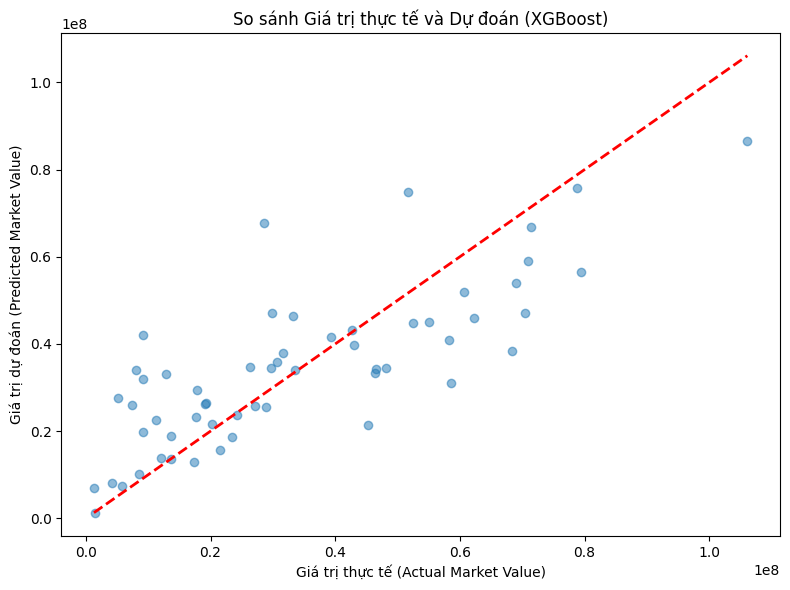

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def convertion(value):
    if isinstance(value, str):
        value = value.replace('€', '').strip()
        if 'M' in value:
            return float(value.replace('M', '')) * 1_000_000
    return None

dfb1 = pd.read_csv('result.csv')
df_filtered = dfb1[dfb1['minutes'] > 900].copy()

dfb4 = pd.read_csv('b4.csv')
dfb4['MarketValueNum'] = dfb4['MarketValue'].apply(convertion)

df = dfb1.merge(
    dfb4[['player', 'minutes', 'MarketValue', 'MarketValueNum']],
    how='left',
    on=['player', 'minutes']
)

df = df.dropna(subset=['MarketValueNum'])

df['age_num'] = df['age'].astype(str).str[:2].astype(int)

important_features = [
    'age_num', 'touches_att_3rd', 'touches_att_pen_area', 'progressive_passes_x',
    'sca', 'passes_into_final_third', 'passes_into_penalty_area',
    'shots_on_target_per90', 'carries', 'passes_pct_medium', 'passes_pct',
    'carries_progressive_distance', 'ball_recoveries', 'goals_per90',
    'xg', 'xg_per90', 'passes_pct_long', 'goals', 'touches_def_3rd',
    'crosses', 'games_starts', 'assists', 'passes_completed', 'touches'
]

X = df[important_features]
y = df['MarketValueNum']

X = X.dropna()
y = y.loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = xgb.XGBRegressor(
    n_estimators=900,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)


y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('So sánh Giá trị thực tế và Dự đoán (XGBoost)')
plt.xlabel('Giá trị thực tế (Actual Market Value)')
plt.ylabel('Giá trị dự đoán (Predicted Market Value)')
plt.tight_layout()
plt.show()
